<a href="https://colab.research.google.com/github/JackHidary/quantumcomputingbook/blob/master/Notes/Cirq_Workshop_Bootcamp_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Cirq](https://github.com/quantumlib/cirq/raw/master/docs/Cirq_logo_color.svg?sanitize=true)


[Cirq](https://github.com/quantumlib/cirq) is a framework for writing quantum algorithms for noisy intermediate scale quantum (NISQ) devices. Roughly speaking, NISQ devices are those with O(100) qubits that can enact O(1000) gates.  Because the resources for NISQ devices are so constrained we believe that a framework for writing programs on these devices needs to be aware of all of the architectural properties of the device on which the algorithm is written. This is in contrast to other frameworks where there is a clean separation between the abstract model being used and the details of the device.  

In this tutorial we will teach you the basics of writing quantum alogorithms in Cirq. Our goal will be to write a variational ansatz for use in an optimization algorithm.

---



>>[Installing Cirq](#scrollTo=rPgPbry6-mF3)

>>[Qubits, Moments, Operations, and Circuits](#scrollTo=8A7a3jcql1l5)

>>>[Create a Circuit](#scrollTo=VFwmWPf7D057)

>>>[Building Circuits](#scrollTo=uaDb6B_jPgrb)

>>>[Exercise: Create a circuit](#scrollTo=y9conKPAPn26)

>>>>[Solution](#scrollTo=KnA4uBkwEw5-)

>>[Simulations of a Circuit](#scrollTo=X15yPl_KQ20Z)

>>>[Repetitions](#scrollTo=YLpiz0aN1Jd6)

>>[The Deutsch-Jozsa Algorithm](#scrollTo=qFsytBIbOVD8)

>>>[Exercise: Two Bit Deutsch-Jozsa Algorithm](#scrollTo=v4ka34Kuj4K0)

>>>>[Solution](#scrollTo=L6vfs97CFZB2)

>>[Gates](#scrollTo=mmhbPIhT4YAI)

>>>[Custom Gate Implementation](#scrollTo=RACz4Z5GDMAf)

>>>[Exercise: Custom Controlled Rx gate](#scrollTo=y63aDja8R4rc)

>>>>[Solution](#scrollTo=7SoneHQRGeUW)

>>>[Gate decompositions](#scrollTo=9W_Vlgpzz0D1)

>>[Parameterized Circuits](#scrollTo=3HtlMxa6QpVo)

>>>[Exercise: Rotate a qubit](#scrollTo=r-CjbPwkRI_I)

>>[Noise](#scrollTo=FEM73JPALREa)

>>>[Monte carlo simulations](#scrollTo=3qUM-Kpi8Iy4)

>>>[Adding Noise to Circuits and Simulations](#scrollTo=weWPzaPx8zly)

>>[Devices](#scrollTo=PvJCA3e0QsuI)

>>>[Exercise: Make a Device](#scrollTo=lyFcloaARXg4)

>>[Compiling / Optimizing](#scrollTo=J9ia4eatUQ_x)

>>>[Exercise: Simplify flipped CNOTs](#scrollTo=--aUfkiaUb3S)

>>[Google's Xmon Gates](#scrollTo=gM1ZW7TstvK9)



---
## Installing Cirq

To use Cirq one first needs to install Cirq.  Installation instructions are available [at cirq.readthedocs.io under 'Installing Cirq'](https://cirq.readthedocs.io/en/latest/install.html).  For the purpose of using this notebook, you can run pip install to install the latest release of Cirq.  Different notebook execution systems exist but for most they have "run" button on a cell, which you can push, or <shift>-<enter> is often the shortcut to run th cell.  Do so in the following cell should install Cirq. 

In [0]:
# install latest version
!pip install cirq==0.5 --quiet

# Alternatively, install directly from HEAD on github:
# !pip install git+https://github.com/quantumlib/Cirq.git --quiet

     |████████████████████████████████| 716kB 2.9MB/s 
     |████████████████████████████████| 12.8MB 42.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


(Note: you may see an error about `albumentations` requiring an old `imgaug`. You can ignore this error.)

Let's check that Cirq has been successfully installed by importing Cirq and priting out a diagram of the Google's Bristlecone device. ![Google's Bristecone chip](https://4.bp.blogspot.com/-b9akad6ismU/WpmyaJo-cYI/AAAAAAAACa8/mCqPBJxv5oUivy6Jq42FSOQYkeRlTmkiwCLcBGAs/s1600/image1.png)

In [0]:
import cirq
import numpy as np
import matplotlib 
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

The import ran without raising an error, and the output is in fact the grid of qubits for the Bristlecone device. Looks like the install worked!

Be aware that Cirq is still alpha software, meaning **we are still making breaking changes all the time**. If you don't want your project to suddenly go from working to not working when we release a new version, you should depend on a *specific version* of Cirq and periodically bump that version to the latest one. For the purposes of this tutorial, we will use version of `0.5` (i.e. `cirq==0.5` in pip's version notation).

---

## Qubits, Moments, Operations, and Circuits
 
 In Cirq, circuits are represented either by a `Circuit` object or a `Schedule` object. `Schedule`s offer more control over quantum gates and circuits at the timing level.

Conceptually: a `Circuit` is a collection of `Moment`s. A `Moment` is a collection of `Operation`s that all act during the same abstract time slice. An `Operation` is a an effect that operates on a specific subset of Qubits. The most common type of `Operation` is a `Gate` applied to several qubits (a "`GateOperation`"). The following diagram should help illustrate these concepts.

![Circuits, Moments, and Operations.](https://cirq.readthedocs.io/en/latest/_images/CircuitMomentOperation.png)

### Create a Circuit

Let's create a `Circuit`.  Note that in the previous cell we imported cirq, so we will assume that cirq has been imported through out the rest of this notebook.

In [0]:
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b, c), cirq.H(b)]
circuit = cirq.Circuit.from_ops(ops)
print(circuit)

a: ───H───────────

b: ───H───@───H───
          │
c: ───────X───────


We can unpack this a bit and see all of the components for the circuit.


The first thing we do is pick some qubits to use. There are many different types of qubits in Cirq, and you can define your own by inheriting from the `cirq.Qid` class. There's nothing inherently special or magical about these quantum id types such as `cirq.NamedQubit`. They simply identify what you wish to operate on, which is relevant when you are targeting a specific device. For example, if we were creating a circuit for the Bristlecone device we would use `cirq.GridQubit(5, 0)` to refer to the qubit in the left most position of the device. To keep these simple for now, we'll start with abstract qubits simply identified by a name such as "a".
```
a = cirq.NamedQubit("a")
```

Next we encounter of the object `cirq.H`, which is a Hadamard gate.  `cirq.H` is an instance of the `cirq.HGate` class, which itself is a subclass of `Gate` (along with other classes). 
$$H = {1 \over \sqrt{2}} \left[ \begin{array}[cc]  & 1 & 1  \\ 1 & -1 \end{array}\right]$$
We can use cirq to see this unitary matrix:

In [0]:
cirq.unitary(cirq.H)

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

`Gate` objects have the ability to applied "on" to one or more qubits.  There are two ways to do this for gates, either using the `on` method or by directly calling the gate on the qubits as if the gate were a function and the qubits were arguments.  For example to apply the `H` onto qubit `a` we can say
```
cirq.H.on(a)
```
or 
```
cirq.H(a)
```

The result of those expressions is a `GateOperation` object, which is a type of `Operation`.

In cirq we make a strong distinction between `Operation`s and `Gate`s. An `Operation` is associated with specific qubits and can be put in `Circuit`s. A `Gate` has unspecified qubits, and will produce an operation when given qubits.

Once you have a collection of operations, you can construct a `Circuit` using the class method `Circuit.from_ops` (more on that in a minute):
```
circuit = cirq.Circuit.from_ops(ops)
```
The last thing we did in the example code was use the (surprisingly useful) ability to print the circuit as a text diagram.

The diagram is visually helpful, but it doesn't really get into the internal details of how the `Circuit` is represented. 
A `Circuit` is made up of a sequence of `Moment` objects.
And each `Moment` object is a list of non-overlapping `Operation`s.
To see this internal structure, we can iterate over the `Moment`s in the `Circuit` while printing them out.

In [0]:
for i, moment in enumerate(circuit):
    print('Moment {}: {}'.format(i, moment))

Moment 0: H(a) and H(b)
Moment 1: CNOT(b, c)
Moment 2: H(b)


We can also just print the circuit's `repr`, which returns a somewhat more detailed (if less readable) expression.

In [0]:
print(repr(circuit))

cirq.Circuit(moments=[
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('a')),
        cirq.H.on(cirq.NamedQubit('b')),
    ]),
    cirq.Moment(operations=[
        cirq.CNOT.on(cirq.NamedQubit('b'), cirq.NamedQubit('c')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('b')),
    ]),
])


The usefulness of printing the `repr` is that it includes *all* the gory details.
These details can be useful when debugging.
The `repr` is also a valid python expression that evaluates to the circuit.
For example, if we notice that a circuit generated in some complicated way triggers a bug in a simulator, copy-pasting the generated circuit's `repr` into a test, and then working from there, is a simple way to decouple the reproduction of the bug from the circuit generation code.

### Building Circuits
Above we created the `Circuit` using `from_ops`.  But there are many ways to construct and modify circuits, and each of these is useful in different contexts.  Here are a few examples:


1.   `from_ops`: This is the simplest way to make a circuit. Give this method some operations, and out pops a circuit.
2.  `append`:  `Circuit`s are mutable. You can start with an empty `c = cirq.Circuit()` and simply `c.append(operations)` to add on more and more operations 
3. `insert`:  Instead of appending, you can insert before a particular moment location (labeled by an integer index)
4.  By using `Circuit`'s constructor, which takes a list of `Moment`s. Each `Moment` must be explicitly constructed with its own list of `Operation`s. This is tedious, but gives complete control over how the operations are layed out.

One interesting, and extremely convenient, fact about `from_ops`, `append`, and `insert` is that they "auto flatten" whatever you give them.
You *can* give them a list of operations, but you can also give them a list *of lists* of operations.
Or a generator function that sometimes yields tuples of operations and other times yields individual operations.
Or just a single operation (without a list around it).
If it can recursively iterated into individual operations, `from_ops` and `append` and `insert` will take it.

The main place where auto-flattening is useful is when you are generating a circuit's operations using generator functions.
This is jumping a bit ahead of what we've explained, but basically auto-flattening means that generators producing operations for a circuit can simply `yield` sub-generators (instead of iterating over them and yielding their items):


In [0]:
def xor_swap(a, b):
    yield cirq.CNOT(a, b)
    yield cirq.CNOT(b, a)
    yield cirq.CNOT(a, b)
  
def left_rotate(qubits):
    for i in range(len(qubits) - 1):
        a, b = qubits[i:i+2]
        yield xor_swap(a, b)

line = cirq.LineQubit.range(5)
print(cirq.Circuit.from_ops(left_rotate(line)))

0: ───@───X───@───────────────────────────────────────
      │   │   │
1: ───X───@───X───@───X───@───────────────────────────
                  │   │   │
2: ───────────────X───@───X───@───X───@───────────────
                              │   │   │
3: ───────────────────────────X───@───X───@───X───@───
                                          │   │   │
4: ───────────────────────────────────────X───@───X───


You may have noticed that there is a hole in what we've explained so far.
`from_ops` effectively takes a 1-dimensional sequence of operations, but the output is a 2-dimensional circuit (a list-of-lists-of-operations).
There is a degree of freedom that hasn't been account for.
Specifically: how does cirq choose the moment that each operation will be placed within?
The answer is: it depends on the  `InsertStrategy` you choose.

There are currently four insertion strategies in Cirq:

1.  `InsertStrategy.EARLIEST` (currently the default)
2. `InsertStrategy.NEW`,
3. `InsertStrategy.INLINE`
4.  `InsertStrategy.NEW_THEN_INLINE` 

`InsertStrategy.EARLIEST` is defined as
> `InsertStrategy.EARLIEST`: Scans backward from the insert
> location until a moment with operations touching qubits affected by the
> operation to insert is found. The operation is added into the moment just
> after that location.

For example, if we first create an `Operation` in a single moment,
and then use `InsertStrategy.EARLIEST` the `Operation` can slide back to this
first `Moment` if there is space

An `InsertStrategy` defines how ``Operations`` are placed in a `Circuit` when requested to be inserted at a given location.
Here a `location` is identified by the index of the `Moment` in the `Circuit` that operations should be placed before (in the case of `Circuit.append` this means inserting at the index `len(circuit)`; which is one more than the largets moment index and so represents the end of the circuit).

In [0]:
circuit = cirq.Circuit()
circuit.append([cirq.CZ(a, b)])
circuit.append([cirq.H(a), cirq.H(b), cirq.H(c)])
print(circuit)

a: ───@───H───
      │
b: ───@───H───

c: ───H───────


After creating the first moment with a `CZ` gate, the second
append uses the `InsertStrategy.EARLIEST` strategy. The
`H` on ``a`` and ``b`` cannot slide back, while the `H` on ``c`` can and so ends up in the first `Moment`.

`InsertStrategy.EARLIEST` is the default strategy, the second most important strategy is `InsertStrategy.NEW_THEN_INLINE`:
> `InsertStrategy.NEW_INLINE`: For the first operation, add it to a new 
> `Moment` the insertion point.  Attempts to add the operation after the first 
> operation to insert into the moment just before the desired insert location. 
> But, if there's already an existing operation affecting any of the qubits
> touched by the operation to insert, a new moment is created instead and this 
> `Moment` is the one that is subsequently used for insertions.

As an example of this examine this code

In [0]:
circuit = cirq.Circuit()
circuit.append([cirq.CZ(a, b)])
circuit.append([cirq.H(c), cirq.H(b), cirq.H(b), cirq.H(a)], )
print(circuit)

a: ───@───H───────
      │
b: ───@───H───H───

c: ───H───────────


### Exercise: Create a circuit

Now that you've learned about `InsertStrategy`, here is an exercise to validate your understanding.  Create, using the least number of appends the following circuit (note that printing a circuit in Cirq does not always print a moment by moment structure e.g. to avoid overlapping operations in the diagram, but here imagine that you want exactly the moments indicated by the spacing of the circuit.)



```
a: ───@───H───────────H───H───
      │
b: ───@───────H───@───H───────
                  │
c: ───H───────────@───────────
```



#### Solution

In [0]:
#@title
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
c = cirq.NamedQubit('c')
circuit = cirq.Circuit()
circuit.append([cirq.CZ(a, b), cirq.H(c), cirq.H(a)] )
circuit.append([cirq.H(b), cirq.CZ(b, c), cirq.H(b), cirq.H(a), cirq.H(a)],
               strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
print(circuit)

a: ───@───H───────────H───H───
      │
b: ───@───────H───@───H───────
                  │
c: ───H───────────@───────────


## Simulations of a Circuit

Now that you know how to construct a `Circuit` in Cirq, let's use Cirq to simulate the circuit.

Here is a simple circuit

In [0]:
def basic_circuit(measure=True):
    sqrt_x = cirq.X**0.5
    cz = cirq.CZ
    yield sqrt_x(a), sqrt_x(b)
    yield cz(a, b)
    yield sqrt_x(a), sqrt_x(b)
    if measure:
        yield cirq.measure(a,b)
        
circuit = cirq.Circuit.from_ops(basic_circuit())
print(circuit)

a: ───X^0.5───@───X^0.5───M───
              │           │
b: ───X^0.5───@───X^0.5───M───


There are a few things to note here.  

One is that we have used a Python *generator*. Recall that in Python functions that have a `yield` are *generators*. Generators are functions that act as *iterators*. Above we see that we can iterate over ``basic_circuit()``. We see that when we do this each of the `yields` produces what was yielded, and here these are `Operations`,
or lists of ``Operations``. But when we pass this iterator to the append method, something magical happens. `Circuit` is able to flatten all of these an pass them as one giant list to `Circuit.append` (this also works for `Circuit.insert`).
> The above idea uses a concept we call an ``OP_TREE``. An ``OP_TREE`` is
> not a class, but a contract. The basic idea is that, if the input can be
> iteratively flattened into a list of operations, then the input is an
> ``OP_TREE``.

A very nice pattern emerges from this structure: define *generators* for sub-circuits, which can vary by size
or `Operation` parameters.

Now we can simulate this circuit.

In [0]:
simulator = cirq.Simulator()
circuit = cirq.Circuit.from_ops(basic_circuit())
result = simulator.run(circuit)
print('Measurement results')
print(result)

Measurement results
a,b=1, 0


Running this multiple times should result in different measurement results, since the above circuit produces a superposition over all computational basis states.   

Above we used the `run` method on the simulator.  These methods mimic the actual hardware in that they don't give one access to unphysical objects like the wavefunction.  If one wants to get the wave function, then the `simulate` methods can do this:


In [0]:
circuit = cirq.Circuit()
circuit.append(basic_circuit(measure=False))    
result = simulator.simulate(circuit, qubit_order=[a, b])

print('Wavefunction:')
print(np.around(result.final_state, 3))
print('Dirac notation:')
print(result.dirac_notation())

Wavefunction:
[0.5+0.j  0. +0.5j 0. +0.5j 0.5+0.j ]
Dirac notation:
0.5|00⟩ + 0.5j|01⟩ + 0.5j|10⟩ + 0.5|11⟩


Notice that we passed a `qubit_orde`r into the `simulate` method.  This order helps define the order of the kronecker product used in the resulting `final_state` vector.  The `qubit_order` argument is optional. When it is omitted, qubits are sorted ascending according to the ordering methods defined by their python class (for example `cirq.NamedQubit` sorts lexicographically by name).
If there are multiple types of qubits in one circuit, the name of the type is used as a tie breaker.

The simplest `qubit_order` value you can provide is a list of the qubits in the desired ordered. Any qubits from the circuit that are not in the list will be ordered using the  default `__str__` ordering, but come after qubits that are in the list. Be aware that all qubits in the list are included in the simulation, even if they are not operated on by the circuit.

The mapping from the order of the qubits to the order of the  amplitudes in the wave function can be tricky to understand.  Basically, it is the same as the ordering used by `numpy.kron`.

> If wave function is array 
>>(0.1, 0.2, 0.3, 0.4)

> then this is 
>> 0.1|00⟩ + 0.2|01⟩ + 0.3|10⟩ + 0.4|11⟩ 

>in Dirac notation.  If the 
>> qubit order = [a, b]

>then |00> means qubit a is in 0 and qubit b is in 0, |01> means 
> qubit a is 0 and qubit b is 1, etc.

Another way to think about the qubit-to-amplitude ordering is as "for loop ordering":

```
for a in [0, 1]:
    for b in [0, 1]:
        print(a, b)
```

The first index (the outermost loop) is the slowest to vary.

### Repetitions

The simulator `run` methods also take an option for repeating the circuit. If 
the measurements in the circuit are terminal, and all other operations are unitary, this simulator is optimized to not recompute the wavefunction before sampling from the circuit.  So for example this code doesn't recompute the wave function but knows to sample from the final measurements

In [0]:
circuit = cirq.Circuit.from_ops(basic_circuit())
result = simulator.run(circuit, repetitions=1000)
print(result.histogram(key='a,b'))

Counter({1: 261, 2: 248, 3: 247, 0: 244})


Here we have also demonstrated the use of the `histogram` method on the `result` which sums over all the different results for all of the different repetitions.

The `histogram` method can also be given a `fold_func` argument, in order to group measurement results under some key before counting them up.
For example, we can group by whether or not the two measurement results agreed:

In [0]:
print(result.histogram(key='a,b', fold_func=lambda e: 'agree' if e[0] == e[1] else 'disagree'))

Counter({'disagree': 509, 'agree': 491})


## The Deutsch-Jozsa Algorithm

The very first indication that quantum computers could be more powerful than classical computers was provided by David Deutsch in his 1985 paper:
> David Deutsch,  "Quantum Theory, the Church-Turing Principle and the Universal Quantum Computer" Proceedings of the Royal Society of London A. 400: 97 [PDF](https://people.eecs.berkeley.edu/~christos/classics/Deutsch_quantum_theory.pdf)

This algorithm was extended by Deutsch and Richard Jozsa to a more convincing algorithmic seperation and what is now called the Deutsch-Jozsa algorithm.  In this section we will show how to write circuits for the Deutsch algorithm and then as an exercise in using Cirq for algorithms for a small version of the Deutsch-Jozsa algorithm.

Let's begin with the Deutsch algorithm.  In Deutsch's algorithm you are given access to a box which computes a one bit boolean function.  That is it is a box which takes in a bit and outputs a bit.  If we want to be a mathematician or theoretical computer scientist we write the function $f$ as $f: \{0, 1\} \rightarrow \{0, 1\}$.  There are exactly four such boolean functions which we can write out in a table

| $x$ | $f_0$ | $f_1$ | $f_x$ | $f_{\bar{x}}$ |
| --- |  --- | --- | --- | --- |
| 0 | 0 | 1 | 0 | 1
| 1 | 0 | 1 | 1 | 0

The first two of these are *constant* functions, $f_0$ and $f_1$.  That is they always output a constant value.  The other two $f_x$ and $f_\bar{x}$ are *balanced*.  Over their inputs $0$ and $1$, they have an equal number of $0$s and $1$s in their truth table.  

We can now state Deutsch's problem:

> Given access to a one bit input one bit output boolean function, determine, by querying the function whether the function is *balanced* or *constant*.

It shouldn't take you much to convince yourself that in order to solve this problem classically you need to call the function on both possible input values.  The easy way to see this is just to consider what happens if you query the function on one particular input and notice that for either input learning the value of the function does not separate the constant from balanced functions.

**Classically one must query the binary function twice to distinguish the constant function from the balanced function.**







Now lets turn to the quantum approach to this problem.  There is one bit of book keeping we need to take care of.  Above we have described a classical function on bits that is not reversible.  That is, knowing the values of the output does not allow us to determine uniquely the value of the input.  In order to run this on a quantum computer, however we need to make this computation reversible.  A trick for taking a classical non-reversible function and making it quantum happy is to compute the value in an extra register.  Suppose we have an $n$ bit input $x$ and we are computing a (potentially non-reverisble) boolean function $f(x)$.  Then we can implement this via a Unitary $U_f$ that acts like on $n + 1$ qubits

$$U_f |x\rangle |y\rangle = |x\rangle | y \oplus f(x)\rangle$$

Here $\oplus$ is addition modulo $2$ (XOR) and we have identified how $U_f$ acts by its action on all computational basis states $|x\rangle$ ($n$ input qubits) and ($1$ output qubit)$|y\rangle$. To see that this is reversible one can note that applying the transformation twice returns the state to its original form.

Let's see how to implement these functions in Cirq.

$f_0$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |00\rangle \\
|01\rangle &\rightarrow&  |01\rangle \\
|10\rangle &\rightarrow&  |10\rangle \\
|11\rangle &\rightarrow&  |11\rangle \\
\end{eqnarray}
$$
Well this is just the identity transform, i.e. an empty circuit.

$f_1$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |01\rangle \\
|01\rangle &\rightarrow&  |00\rangle \\
|10\rangle &\rightarrow&  |11\rangle \\
|11\rangle &\rightarrow&  |10\rangle \\
\end{eqnarray}
$$
This is the `cirq.X` bit flip gate on the second qubit.

$f_x$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |00\rangle \\
|01\rangle &\rightarrow&  |01\rangle \\
|10\rangle &\rightarrow&  |11\rangle \\
|11\rangle &\rightarrow&  |10\rangle \\
\end{eqnarray}
$$
This is nothing more than a `cirq.CNOT` from the first bit to the second bit.

Finally $f_\bar{x}$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |01\rangle \\
|01\rangle &\rightarrow&  |00\rangle \\
|10\rangle &\rightarrow&  |10\rangle \\
|11\rangle &\rightarrow&  |11\rangle \\
\end{eqnarray}
$$
which is a `cirq.CNOT` from the first bit to the second bit followed by a `cirq.X` on the second bit.

We can encapulate these functions into a dictionary from a oracle name to the ops in the circuit needed to enact this function:


In [0]:
q0, q1 = cirq.LineQubit.range(2)
oracles = {
    '0': [],
    '1': [cirq.X(q1)],
    'x': [cirq.CNOT(q0, q1)],
    'notx': [cirq.CNOT(q0, q1), cirq.X(q1)]
}    

Turning now to Deutch's algorithm.  Suppose we are given access to the reversible oracle functions we have defined before.  By a similar argument for our irreversible classical functions you can show that you cannot distinguish the balanced from the constant functions by using this oracle only once.  But now we can ask the question: what if we are allowed to query this box in superposition, i.e. what if we can use the power of quantum computing?

Deutsch was able to show that you could solve this problem now, with quantum computers, using only a single query of the box.  To see how this works we need two simple insights.

Suppose that we prepare the second qubit in the superposition state $|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ and apply  the oracle.  Then we can check that
$$ 
U_f |x\rangle |-\rangle = U_f|x\rangle \frac{1}{\sqrt{2}}(|0\rangle -|1\rangle ) = |x\rangle \frac{1}{\sqrt{2}}(|f(x)\rangle -|f(x) \oplus 1\rangle ) =  (-1)^{f(x)} |x\rangle |-\rangle
$$  
This is the so called "phase kickback trick".  By applying $U_f$ onto a target which is in superposition, the value of the function ends up showing up in the global phase.  

How can we leverage this to distinguish between the constant and balanced functions?  Note that for the constant functions the phase that is applied is the same for all inputs $|x\rangle$, whereas for the balanced functions the phase is different for each value of $x$.   Another way to say that is that if we use the phase kickback trick then for each of the oracles we apply the following transform on the first qubit.
$$
\begin{eqnarray}
f_0 \rightarrow I, &&
f_1 \rightarrow -I, &&
f_x \rightarrow Z, &&
f_\bar{x} \rightarrow -Z &&
\end{eqnarray}
$$
Now we only need, on the first qubit, to distinguish between the identity gate and the $Z$ gate.  But we can do this by recalling the identity
$$ H Z H = X$$
where $H$ is the Hamadard gate
$$H = {1 \over \sqrt{2}} \left[ \begin{array}[cc]  & 1 & 1  \\ 1 & -1 \end{array}\right]$$
This means that we can turn a phase flip into a bit flip by applying Hadamards before and after the phase flip.  If we look at the constant and balanced functions we see that this means that the constant functions will be proportional to $I$ and the balanced will be proportional to $X$.  If we feed in $|0\rangle$ to this register, then in the first cases we will only see $|0\rangle$ and in the second case we will see $|1\rangle$.  In other words we will be able to distinguish constant from balanced using a single query of the oracle.


Let's code this up


In [0]:
q0, q1 = cirq.LineQubit.range(2)
oracles = {
    '0': [],
    '1': [cirq.X(q1)],
    'x': [cirq.CNOT(q0, q1)],
    'notx': [cirq.CNOT(q0, q1), cirq.X(q1)]
}    

def deutsch_algorithm(oracle):
    yield cirq.X(q1)
    yield cirq.H(q0), cirq.H(q1)
    yield oracle
    yield cirq.H(q0)
    yield cirq.measure(q0)

for key, oracle in oracles.items():
    print('Circuit for {}...'.format(key))
    print('{}\n'.format(cirq.Circuit.from_ops(deutsch_algorithm(oracle))))

Circuit for 0...
0: ───H───H───M───

1: ───X───H───────

Circuit for 1...
0: ───H───H───M───

1: ───X───H───X───

Circuit for x...
0: ───H───────@───H───M───
              │
1: ───X───H───X───────────

Circuit for notx...
0: ───H───────@───H───M───
              │
1: ───X───H───X───X───────



Lets run these circuits a bunch of times to see that the measurement result ends up correctly distinguishing constant from balanced.

In [0]:
simulator = cirq.Simulator()
for key, oracle in oracles.items():
    result = simulator.run(cirq.Circuit.from_ops(deutsch_algorithm(oracle)), 
                          repetitions=10)
    print('oracle: {:<4} results: {}'.format(key, result))

oracle: 0    results: 0=0000000000
oracle: 1    results: 0=0000000000
oracle: x    results: 0=1111111111
oracle: notx results: 0=1111111111


### Exercise: Two Bit Deutsch-Jozsa Algorithm

All boolean functions for one input bit are either constant or balanced.  For boolean functions from two input bits not all functions are constant or balanced.  There are two constant functions, $f(x_0, x_1) = 0$ and $f(x_0, x_1)=1$, while there are ${4 \choose 2} = 6$ balanced functions.  The following code gives you the operations for these functions where we take two input qubits and compute the function in the third qubit


In [0]:
q0, q1, q2 = cirq.LineQubit.range(3)
constant = ([], [cirq.X(q2)])
balanced = ([cirq.CNOT(q0, q2)], [cirq.CNOT(q1, q2)], [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2)],
            [cirq.CNOT(q0, q2), cirq.X(q2)], [ cirq.CNOT(q1, q2), cirq.X(q2)], [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2), cirq.X(q2)])
for i, ops in enumerate(constant):
    print('\nConstant function {}'.format(i))
    print(cirq.Circuit.from_ops(ops).to_text_diagram(qubit_order=[q0, q1, q2]))
    print()

for i, ops in enumerate(balanced):
    print('\nBalanced function {}'.format(i))
    print(cirq.Circuit.from_ops(ops).to_text_diagram(qubit_order=[q0, q1, q2]))
    



Constant function 0
0: ───

1: ───

2: ───


Constant function 1
0: ───────

1: ───────

2: ───X───


Balanced function 0
0: ───@───
      │
1: ───┼───
      │
2: ───X───

Balanced function 1
0: ───────

1: ───@───
      │
2: ───X───

Balanced function 2
0: ───@───────
      │
1: ───┼───@───
      │   │
2: ───X───X───

Balanced function 3
0: ───@───────
      │
1: ───┼───────
      │
2: ───X───X───

Balanced function 4
0: ───────────

1: ───@───────
      │
2: ───X───X───

Balanced function 5
0: ───@───────────
      │
1: ───┼───@───────
      │   │
2: ───X───X───X───


An extension of Deutsch's orginal algorithm is the Deutsch-Jozsa algorithm, which can distinguish constant from balanced functions like these using a single query to the oracle.  Write a quantum circuit that can distinguish these 

In [0]:
simulator = cirq.Simulator()
def your_circuit(oracle):
    # your code here
    yield oracle
    # and here
    yield cirq.measure(q0, q1, q2)

print('Your result on constant functions')
for oracle in constant:
    result = simulator.run(cirq.Circuit.from_ops(your_circuit(oracle)), repetitions=10)
    print(result)
    
print('Your result on balanced functions')
for oracle in balanced:
    result = simulator.run(cirq.Circuit.from_ops(your_circuit(oracle)), repetitions=10)
    print(result)

#### Solution

In [0]:
#@title
simulator = cirq.Simulator()
def your_circuit(oracle):
    # phase kickback trick
    yield cirq.X(q2), cirq.H(q2)
    
    # equal superposition over input bits
    yield cirq.H(q0), cirq.H(q1)
    
    # query the function
    yield oracle
    
    # interference to get result, put last qubit into |1>
    yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
    
    # a final OR gate to put result in final qubit
    yield cirq.X(q0), cirq.X(q1), cirq.CCX(q0, q1, q2)
    yield cirq.measure(q2)
    

print('Your result on constant functions')
for oracle in constant:
    result = simulator.run(cirq.Circuit.from_ops(your_circuit(oracle)), repetitions=10)
    print(result)
    
print('Your result on balanced functions')
for oracle in balanced:
    result = simulator.run(cirq.Circuit.from_ops(your_circuit(oracle)), repetitions=10)
    print(result)

Your result on constant functions
2=0000000000
2=0000000000
Your result on balanced functions
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111


## Gates

Cirq comes with a plethora of different common gates.  Here we show a few of them.

In [0]:
q0, q1, q2 = cirq.LineQubit.range(3)
ops = [
    cirq.X(q0),
    cirq.Y(q1),
    cirq.Z(q2),
    cirq.CZ(q0,q1),
    cirq.CNOT(q1,q2),
    cirq.H(q0),
    cirq.T(q1),
    cirq.S(q2),
    cirq.CCZ(q0, q1, q2),
    cirq.SWAP(q0, q1),
    cirq.CSWAP(q0, q1, q2),
    cirq.CCX(q0, q1, q2),
    cirq.ISWAP(q0, q1),
    cirq.Rx(0.5 * np.pi)(q0),
    cirq.Ry(.5 * np.pi)(q1),
    cirq.Rz(0.5 * np.pi)(q2),
    (cirq.X**0.5)(q0),
]
print(cirq.Circuit.from_ops(ops))

0: ───X───@───H───────@───×───@───@───iSwap──────Rx(0.5π)───X^0.5───
          │           │   │   │   │   │
1: ───Y───@───@───T───@───×───×───@───iSwap──────Ry(0.5π)───────────
              │       │       │   │
2: ───Z───────X───S───@───────×───X───Rz(0.5π)──────────────────────


For each of these gates, you can figure out how they act on the computational basis by calling `cirq.unitary` on the gate.  For example

In [0]:
print(cirq.unitary(cirq.CNOT))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


In [0]:
print(cirq.unitary(cirq.Rx(0.5 * np.pi)))

[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]


For single qubit gates, we have named gates like `cirq.H` for the Hadmard gate, but probably more useful are the single qubit rotation gates.

$$ 
{\tt cirq.Rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.Ry(θ)}: \exp(-i \theta Y) = cos \theta I - i \sin \theta Y =\left[ \begin{array} ~\cos \theta &  -\sin \theta \\  \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.Rz(θ)}: \exp(-i \theta Z) = cos \theta I - i \sin \theta Z =\left[ \begin{array} ~e^{i \theta} & 0 \\ 0 & e^{-i \theta} \end{array} \right] \\
$$ 

In addition to `cirq.unitary` another important method (behind the scenes, anyways) is `cirq.apply_unitary_to_tensor`.  This allows you to apply a unitary gate onto a state.  Of course we could have applied the unitary directly to the state, using `cirq.unitary`.   We'll see below in understanding how these methods are implemented that the `cirq.apply_unitary_to_tensor` can be used to apply the gate more directly onto the state and can save allocations of memory to store the unitary.  

If we apply `cirq.Rx` to a state we can see how it rotates the state.  To do this let us introduce a new simulate method `simulate_moment_steps`.  This allows us to simulate the circuit `Moment` by `Moment`.  At each point we can access the state.  For example here we can use this to create a circuit that is a series of small `cirq.Rx` rotations and plot the probablility of measureing the state in the $|0\rangle$ state:

Circuit is a bunch of small rotations about Pauli X axis:
a: ───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───

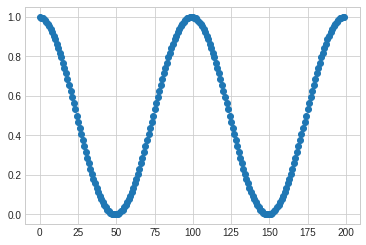

In [0]:
a = cirq.NamedQubit('a')
circuit = cirq.Circuit.from_ops([cirq.Rx(np.pi / 50.0)(a) for theta in range(200)])
print('Circuit is a bunch of small rotations about Pauli X axis:')
print('{}\n'.format(circuit))
p0 = []
z = []
print('We step through the circuit and plot the z component of the vector '
      'as a function of index of the moment being stepped over.')
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    prob = np.abs(step.state_vector()) ** 2
    z.append(i)
    p0.append(prob[0])
matplotlib.pyplot.style.use('seaborn-whitegrid')
matplotlib.pyplot.plot(z, p0, 'o')

Above we have given ourselves direct access to the wave function and calculated the exact probabilities.  Suppose we wanted to sample from the wave function at each point instead.  

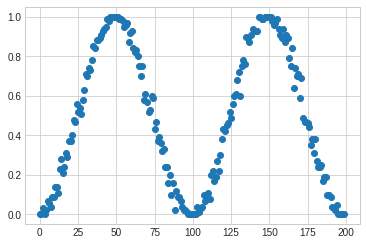

In [0]:
repetitions = 100
a = cirq.NamedQubit('a')
circuit = cirq.Circuit.from_ops([cirq.Rx(np.pi / 50.0)(a) for theta in range(200)])
p0 = []
z = []
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    samples = step.sample([a], repetitions=repetitions)
    prob0 = np.sum(samples, axis=0)[0] / repetitions
    p0.append(prob0)
    z.append(i)
matplotlib.pyplot.style.use('seaborn-whitegrid')
matplotlib.pyplot.plot(z, p0, 'o')

### Custom Gate Implementation

Supose there is a gate that you want Cirq to support, but it is not implemented in Cirq.  How do you go about adding a new gate?  

Cirq tries to be Pythonic.  One way in which it does this is that it relies on Python's **protocol** pattern.  Protocols are similar to interfaces, in that they define a collection of methods that an object must support to implement a protocol, but different in that this requirement is more informal and not a part of a class or interface declaration.  An object supports a protocol if it implements the methods that the protocol defines.  You're probably familiar with this if you've ever done something like defined your own `Container` in Python.  To do this for an object you simply define the `__contains__`, `__setitem__`, and `__getitem__` methods on your object, and then you can use this object anywere the Container protocol is supported.  

Let's see how this works for defining a custom gate.  The gate we will define is a single qubit gate that has only rational amplitudes. This is based on the famous 3, 4, 5 triangle you may remember from a long ago math class: $3^2 + 4^2 = 5^2$.  Using this observation we can construct normalized vectors and a unitary transform using on ratios of $3$, $4$, and $5$: 
$$
\zeta =\left[ \begin{array}
~\frac{3}{5} & \frac{4}{5} \\
-\frac{4}{5} & \frac{3}{5}
\end{array} \right]
$$

Here is a simple implementation of this gate.  To do this we simply define a class that inherits from `cirq.SingleQubitGate` and implements the `cirq.SupportsUnitary` protocol by implementing the `_unitary_(self)` method.  We also define a `__str__` representation and by default Cirq will use this gate when priting out the gate in a circuit diagram.


In [0]:
class RationalGate(cirq.SingleQubitGate):
    
    def _unitary_(self):
        return np.array([[3 / 5, 4 / 5], [-4 / 5, 3 / 5]])
    
    def __str__(self):
        return 'ζ'


a = cirq.NamedQubit('a')
rg = RationalGate()
print(cirq.Circuit.from_ops([rg(a)]))

a: ───ζ───


In [0]:
print(cirq.unitary(rg))

[[ 0.6  0.8]
 [-0.8  0.6]]


Let's check that we can use this gate in a simulation.

In [0]:
circuit = cirq.Circuit.from_ops([rg(a)])
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print(result.final_state)

[ 0.6+0.j -0.8+0.j]


Implemeting `_unitary_` allows cirq to call `cirq.unitary` on an object.

There is actually an interesting advanced subtly here, which is that many methods in cirq that ostensibly depend on a gate's unitary try to avoid the `_unitary_` method, because it is extremely inefficient for gates over many qubits.
In most cases the method `_apply_unitary_to_tensor_` will be used instead, if it is available.
This method allows much more fine grained control on how a unitary is applied to a state, but it is harder to implemented as it is expected to e.g. use the pre-allocated workspace buffer that was given to it.
Almost all of the basic gates we have defined in Cirq have this method implemented.
TL;DR if you need to get performant multiqubit gates you should implement a custom `_apply_unitary_to_tensor_`.

### Exercise: Custom Controlled Rx gate

Recall that the `cirq.Rx` gate is a rotation about the $X$ pauli axis:
$$ 
{\tt cirq.Rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] \\
$$ 

As an exercise, create a two qubit controlled `cirq.Rx` gate:
$$
{\tt CRx(\theta)}:
\left[\begin{array}
~1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0  \\
0 & 0 & \cos \theta & -i \sin \theta \\
0 & 0 & -i \sin \theta & \cos \theta
\end{array} \right]
$$

In [0]:
class CRx(cirq.TwoQubitGate):

    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
      return np.array([
        
      ])
    

    
    pass

    # Get this to print nicely in an ASCII circuit, you should also
    # implement the _circuit_diagram_info_ method from the
    # SupportsCircuitDiagramInfo protocol. You can return a tuple
    # of strings from this method.


print(np.around(cirq.unitary(CRx(0.25 * np.pi))))     

[]


In [0]:
# Also get your class to print a circuit correctly.

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
op = CRx(0.25 * np.pi)(a, b)
print(cirq.Circuit.from_ops([op]))


a: ───<__main__.CRx object at 0x7f49e3ad3fd0>───
      │
b: ───#2────────────────────────────────────────


#### Solution

In [0]:
class CRx(cirq.TwoQubitGate):

    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
      return np.array([
          [1, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, np.cos(self.theta), -1j * np.sin(self.theta)],
          [0, 0, -1j * np.sin(self.theta), np.cos(self.theta)]
      ])
    
    def _circuit_diagram_info_(self, args):
        return '@', 'Rx({}π)'.format(self.theta / np.pi)
    

print('cirq.unitary on the gate yields:')
print(np.around(cirq.unitary(CRx(0.25 * np.pi))))
print()

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
op = CRx(0.25 * np.pi)(a, b)
print('Circuit diagram:')
print(cirq.Circuit.from_ops([op]))

### Gate decompositions

In many context, the notion of what gate you can apply is defined either by the physical hardware you are running or perhaps on the quantum error correcting code you are working with.  In quantum computing we typically talk about **gate sets** and work with respect to a given gate set.  Cirq supports gate decomposition via the `decompose` protocol.  Below we show how one can construct a gate that can be decomposed into two gates.

In [0]:
class HXGate(cirq.SingleQubitGate):
    
    def _decompose_(self, qubits):
        return cirq.H(*qubits), cirq.X(*qubits)
    
    def __str__(self):
        return 'HX'
    
HX = HXGate()

a = cirq.NamedQubit('a')
circuit = cirq.Circuit.from_ops([HX(a)])
print(circuit)
print(cirq.Circuit.from_ops(cirq.decompose(circuit)))

a: ───HX───
a: ───Y^0.5───X───X───


Note that this not only decomposed the `HX` gate into `H` and `X`, it also decomposed `H` into `Y**0.5` and `X`.  In order to decompose only once, one can use `cirq.decompose_once`:

In [0]:
print(cirq.Circuit.from_ops(cirq.decompose_once(HX(a))))

a: ───H───X───


When we define a gate, it is good practice to give a default decompose in terms of gates in `common_gates`.  However often you will want to change this decomposition at run time for the specific hardware or context you are working in.  To do this we can define an interceptor function which does this decomposition before falling back to the default.

In [0]:
def my_decompose(op):
    if isinstance(op, cirq.GateOperation) and isinstance(op.gate, HXGate):
        return cirq.Z(*op.qubits), cirq.H(*op.qubits)

cirq.Circuit.from_ops(cirq.decompose(HX(a), intercepting_decomposer=my_decompose))

a: ───Z───Y^0.5───X───

You can also define a predicate that says which gates to keep without decomposing further.
The default predicate is to only keep gates that cannot be decomposed.

In [0]:
def keep_h_and_x(op):
    return isinstance(op, cirq.GateOperation) and op.gate in [cirq.H, cirq.X]

print(cirq.decompose(HX(a), keep=keep_h_and_x))

[cirq.H.on(cirq.NamedQubit('a')), cirq.X.on(cirq.NamedQubit('a'))]


## Parameterized Circuits

In addition to circuit gates with fixed values, Cirq also supports parameterized gates with symbolic values via `sympy`. These are placeholder values, such as `sympy.Symbol('x')`, that will only be resolved at *run-time*. For simulators these values are resolved by providing a `ParamResolver`.  A `ParamResolver` provides a map from the `Symbol`'s name to its assigned value.  Plain python dictionaries can be used whenever a `ParamResolver` is needed.

In [0]:
import sympy as sp

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
simulator = cirq.Simulator()

val = sp.Symbol('s')
pow_x_gate = cirq.X**val
circuit = cirq.Circuit()
circuit.append([pow_x_gate(a), pow_x_gate(b)])
print('Circuit with parameterized gates:')
print(circuit)
print()
for y in range(5):
    result = simulator.simulate(circuit, param_resolver={'s': y / 4.0})
    print('s={}: {}'.format(y, np.around(result.final_state, 2)))

Circuit with parameterized gates:
a: ───X^s───

b: ───X^s───

s=0: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
s=1: [ 0.6 +0.6j   0.25-0.25j  0.25-0.25j -0.1 -0.1j ]
s=2: [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
s=3: [-0.1 +0.1j   0.25+0.25j  0.25+0.25j  0.6 -0.6j ]
s=4: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


Here we see that the `Symbol` is used in two gates, and then the resolver provides this value at run time.

Parameterized values are most useful in defining what we call a `Study`.  A `Study` is a collection of trials, where each  trial is a run with a particular set of configurations and which may be run repeatedly.  Running a study returns a list of `TrialResult`s per set of fixed parameter values and repetitions.  Example:


In [0]:
resolvers = [cirq.ParamResolver({'s': y / 8.0}) for y in range(9)]
circuit = cirq.Circuit()
circuit.append([pow_x_gate(a), pow_x_gate(b)])
circuit.append([cirq.measure(a), cirq.measure(b)])
results = simulator.run_sweep(program=circuit,
                              params=resolvers,
                              repetitions=10)
for i, result in enumerate(results):
    print('params: {}\n{}'.format(result.params.param_dict, result))

params: {'s': 0.0}
a=0000000000
b=0000000000
params: {'s': 0.125}
a=0000000010
b=0001000000
params: {'s': 0.25}
a=0100000000
b=1100000000
params: {'s': 0.375}
a=0000000001
b=0000001010
params: {'s': 0.5}
a=0110111010
b=0110010100
params: {'s': 0.625}
a=1110111110
b=1011011110
params: {'s': 0.75}
a=1110111101
b=1111011111
params: {'s': 0.875}
a=1111111111
b=1111111111
params: {'s': 1.0}
a=1111111111
b=1111111111


Above we passed in a list of `ParamResolver`s to the `params` parameter of `run_sweep`.  But one can also pass in a `Sweepable`.  There are some useful methods for generating `Sweepable`s, for example to generate an equally spaced set of param resolvers one can use `Linspace`


In [0]:
linspace = cirq.Linspace(start=0, stop=1.0, length=11, key='x')
for p in linspace:
    print(p)

cirq.ParamResolver(OrderedDict([('x', 0.0)]))
cirq.ParamResolver(OrderedDict([('x', 0.1)]))
cirq.ParamResolver(OrderedDict([('x', 0.2)]))
cirq.ParamResolver(OrderedDict([('x', 0.3)]))
cirq.ParamResolver(OrderedDict([('x', 0.4)]))
cirq.ParamResolver(OrderedDict([('x', 0.5)]))
cirq.ParamResolver(OrderedDict([('x', 0.6)]))
cirq.ParamResolver(OrderedDict([('x', 0.7)]))
cirq.ParamResolver(OrderedDict([('x', 0.8)]))
cirq.ParamResolver(OrderedDict([('x', 0.9)]))
cirq.ParamResolver(OrderedDict([('x', 1.0)]))


### Exercise: Rotate a qubit

Let's do the equivalent of a Rabi-flop experiment.  That is lets apply an `PowXGate` rotating about the `X` axis for a linearly spaced set of values followed by a computational basis measurement.  The end result should be a plot of the sampled fraction that were $|1\rangle$ as a function of gates of $X^t$ for $t$ between 0 and $1$ for 100 values of $t$ and each result sampled 100 times.

You can use matplotlib to plot this, see example plot code below.

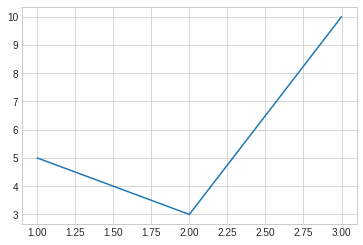

In [0]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [5, 3, 10])

In [0]:
# Insert your code here

## Noise

In addition to circuits with unitary gates, Cirq also has support for modeling noisy quantum evolutions. This is useful when modeling what will happen when running on actual hardware.

Cirq currently supports noise that fits within the context of *operator sum representations* of noise (a.k.a quantum operations, quantum dyanamical maps, superoperators, etc).  This formalism models the evolution of a density matrix via 
$$\rho \rightarrow \sum_k A_k \rho A_k^\dagger$$
where the $A_k$ are *Krauss operators*.  These operators are not necessarily unitary and satisfy the property
$$ \sum_k A_k^\dagger A_k = I$$

An example of a noise operator is the depolarizing channel on one qubit.  This takes
$$\rho \rightarrow (1-p) \rho + \frac{p}{3} (X \rho X + Y \rho Y + Z \rho Z)$$
In Cirq we can define such a channel and use it in a quantum circuit:

In [0]:
circuit = cirq.Circuit.from_ops(cirq.depolarize(0.2)(a), cirq.measure(a))
print(circuit)

a: ───D(0.2)───M───


Previously we saw that gates could implement that `_unitary_` protocol, and by doing so they could be used to perform wave function simulation.  For noise the gates implement the `_channel_` protocol.  Classes that implement this protocol return the Krauss operators on their `_channel_` method.  Thus

In [0]:
for i, krauss in enumerate(cirq.channel(cirq.depolarize(0.2))):
    print('{}th krauss operator is {}'.format(i, krauss))
print()

for i, krauss in enumerate(cirq.channel(cirq.depolarize(0.2))):
    pauli_ex = cirq.expand_matrix_in_orthogonal_basis(krauss, cirq.PAULI_BASIS)
    print('{}th krauss operator is {}'.format(i, pauli_ex))

0th krauss operator is [[0.89442719 0.        ]
 [0.         0.89442719]]
1th krauss operator is [[0.        +0.j 0.25819889+0.j]
 [0.25819889+0.j 0.        +0.j]]
2th krauss operator is [[0.+0.j         0.-0.25819889j]
 [0.+0.25819889j 0.+0.j        ]]
3th krauss operator is [[ 0.25819889+0.j  0.        +0.j]
 [ 0.        +0.j -0.25819889+0.j]]

0th krauss operator is 0.8944271909999159*I
1th krauss operator is 0.2581988897471611*X
2th krauss operator is 0.2581988897471611*Y
3th krauss operator is 0.2581988897471611*Z


In addition to the wave function simulator, Cirq also has a density matrix simulator.  Instead of keeping track of the wave function this simulator keeps track of the density matrix.  It has the same `run` and `simulate` type methods.  For example we can use this to simulate depolarizing channel and return the final density matrix of the system

In [0]:
circuit = cirq.Circuit.from_ops(cirq.depolarize(0.2)(a))
print('Circuit:\n{}\n'.format(circuit))
simulator = cirq.DensityMatrixSimulator()
matrix = simulator.simulate(circuit).final_density_matrix
print('Final density matrix:\n{}'.format(matrix))

Circuit:
a: ───D(0.2)───

Final density matrix:
[[0.8666666 +0.j 0.        +0.j]
 [0.        +0.j 0.13333333+0.j]]


One thing to note is that the density matrix simulator simulates measurement statistically, and not as a channel where the outcome is not known.  Thus for example 

In [0]:
circuit = cirq.Circuit.from_ops(cirq.depolarize(0.2)(a), cirq.measure(a))
simulator = cirq.DensityMatrixSimulator()
for _ in range(5):
    print(simulator.simulate(circuit).final_density_matrix)

[[0.       +0.j 0.       +0.j]
 [0.       +0.j 0.9999999+0.j]]
[[0.       +0.j 0.       +0.j]
 [0.       +0.j 0.9999999+0.j]]
[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]
[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]
[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]


### Monte carlo simulations

Density matrix simulations are more expensive than pure state wave function simulations.  However some channels allow an interpreation of randomly applying one of a fixed set of unitaries with differing probabilites.  For example the depolarizing channel above can be interpretted as: with probability $1-p$ apply the identity to the state and with probability $p$ apply one of the three Pauli matrices $X$, $Y$, or $Z$ with equal probability.  Channels that can be interpretted in this form can be simulating using a wave function simulator: when this channel is simulated the simulation will sample a unitary with the appropriate probability.  

For channels of these type, the channel can, instead of implementing the `_channel_` protocol, implement the `_mixture_` protocol:

In [0]:
for p, u in cirq.mixture(cirq.depolarize(0.2)):
    print('prob={}\nunitary\n{}\n'.format(p, u))

prob=0.8
unitary
[[1. 0.]
 [0. 1.]]

prob=0.06666666666666667
unitary
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

prob=0.06666666666666667
unitary
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

prob=0.06666666666666667
unitary
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]



In fact the depolarizing channel does not implement `_channel_`.  Instead it only implements `_mixture_` and the `cirq.channel` method notices this and derives the channel from the mixture.

In [0]:
d = cirq.depolarize(0.2)
print('does cirq.depolarize(0.2) have _channel_? {}'.format('yes' if getattr(d, '_channel_', None) else 'no'))
print('does cirq.depolarize(0.2) have _mixture_? {}'.format('yes' if getattr(d, '_mixture_', None) else 'no'))

does cirq.depolarize(0.2) have _channel_? no
does cirq.depolarize(0.2) have _mixture_? yes


When channels implement mixture then, as we said, we can use the wave function simulator:

In [0]:
circuit = cirq.Circuit.from_ops(cirq.depolarize(0.5).on(a), cirq.measure(a))
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)
print(result)

a=0100010000


### Adding Noise to Circuits and Simulations

To add noise to circuits or during simulations, we provide the notion of a `NoiseModel`.  A `NoiseModel` may add noise operation by operation, or it may add noise moment by moment, or it may add noise across a list of moments.

For example we can define a noise model that add a single qubit depolarizing for every qubit in each moment.  

In [0]:
noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(0.2))
circuit = cirq.Circuit.from_ops(cirq.H(a), cirq.CNOT(a, b), cirq.measure(a, b))
print('Circuit with no noise:\n{}\n'.format(circuit))

system_qubits = sorted(circuit.all_qubits())
noisy_circuit = cirq.Circuit()
for moment in circuit:
    noisy_circuit.append(noise.noisy_moment(moment, system_qubits))
print('Circuit with noise:\n{}'.format(noisy_circuit))


Circuit with no noise:
a: ───H───@───M───
          │   │
b: ───────X───M───

Circuit with noise:
a: ───H────────D(0.2)───@───D(0.2)───M───D(0.2)───
                        │            │
b: ───D(0.2)────────────X───D(0.2)───M───D(0.2)───


In [0]:
noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(0.2))
circuit = cirq.Circuit.from_ops(cirq.H(a), cirq.CNOT(a, b), cirq.measure(a, b))

simulator = cirq.DensityMatrixSimulator(noise=noise)
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    print('After step {} state was\n{}\n'.format(i, step.density_matrix()))

After step 0 state was
[[0.4333333 +0.j 0.        +0.j 0.31777775+0.j 0.        +0.j]
 [0.        +0.j 0.06666666+0.j 0.        +0.j 0.04888888+0.j]
 [0.31777775+0.j 0.        +0.j 0.4333333 +0.j 0.        +0.j]
 [0.        +0.j 0.04888888+0.j 0.        +0.j 0.06666666+0.j]]

After step 1 state was
[[0.34859255+0.j 0.        +0.j 0.        +0.j 0.17089382+0.j]
 [0.        +0.j 0.15140739+0.j 0.02629136+0.j 0.        +0.j]
 [0.        +0.j 0.02629136+0.j 0.15140739+0.j 0.        +0.j]
 [0.17089382+0.j 0.        +0.j 0.        +0.j 0.34859255+0.j]]

After step 2 state was
[[0.11555554+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.75111103+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.01777777+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.11555553+0.j]]



## Devices

NISQ algorithms work in a regime where every gate counts.  A key philosophy behind Cirq is that we believe the details of the hardware, the performance characteristics, as well as device constraints, will be key to getting the most out of NISQ algorithms.  Towards this end these hardware features are contained in the `Device` class.

For example, here is Google's Bristleconde device

In [0]:
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

In a future version, we intend for each `Device` to define a noise model.

`Device`s also contain more information about the timing of the device.  For example here we can calculate the duration of an `Exp11Gate` on the `Bristlecone` device

In [0]:
brissy = cirq.google.Bristlecone
op = cirq.X.on(cirq.GridQubit(5, 5))
print(brissy.duration_of(op))

20ns


Another property of devices is that they can be used to enforce constraints from the hardware, both checking that these constraints are satisfied, but also enforcing the constraints on the device.  For example on the `Bristlecone` device a two qubit gate has the property that one cannot simultaneously perform a pair of two qubit gates that act on adjacent qubits. So for example if we create such a `Circuit` and validate it using the device it will yell at us

In [0]:
q55 = cirq.GridQubit(5, 5)
q56 = cirq.GridQubit(5, 6)
q66 = cirq.GridQubit(6, 6)
q67 = cirq.GridQubit(6, 7)
ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]
circuit = cirq.Circuit.from_ops(ops)
print(circuit)
print('But when we validate it against the device:')
cirq.google.Bristlecone.validate_circuit(circuit)
# (this should throw an error)

(5, 5): ───@───
           │
(5, 6): ───@───

(6, 6): ───@───
           │
(6, 7): ───@───
But when we validate it against the device:


ValueError: ignored

But more interestingly we could have passed the device into the `Circuit` and it will perform the creation of the circuit (using the insertion semanics as described above) such that the device cannot violate the constraints.

In [0]:
ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]
circuit = cirq.Circuit(device=cirq.google.Bristlecone)
circuit.append(ops)
print(circuit)


(5, 5): ───@───────
           │
(5, 6): ───@───────

(6, 6): ───────@───
               │
(6, 7): ───────@───


### Exercise: Make a Device

Construct a device that acts on a square sized lattice, and only allows Hadamard, CZ, and measurement gates.

In [0]:
# your code here

## Compiling / Optimizing

Cirq's philosophy for what are often called compilation steps is slightly non-traditional.  In particular we believe that NISQ devices perform so few gates that many compiliations will be one or a few passes. A useful class of optimization codee for this is the `PointOptimizer`. For example here is a `PointOptimizer` that recognizes that a `X` gate followed by a `Z` gate is equivalent to a `Y` gate

In [0]:
class XZOptimizer(cirq.PointOptimizer):
    """Replaces an X followed by a Z with a Y."""
    
    def optimization_at(self, circuit, index, op):
        # Is the gate an X gate?
        if isinstance(op, cirq.GateOperation) and (op.gate == cirq.X):
            next_op_index = circuit.next_moment_operating_on(op.qubits, index + 1)
            qubit = op.qubits[0]
            if next_op_index is not None:
                next_op = circuit.operation_at(qubit, next_op_index)
                if isinstance(next_op, cirq.GateOperation) and  (next_op.gate == cirq.Z):
                    new_op = cirq.Y.on(qubit)
                    return cirq.PointOptimizationSummary(
                        clear_span = next_op_index - index + 1,
                        clear_qubits=op.qubits, 
                        new_operations=[new_op])
        
opt = XZOptimizer()
circuit = cirq.Circuit.from_ops(cirq.X(a), cirq.Z(a), cirq.CZ(a, b), cirq.X(a))
print('Before\n{}\n'. format(circuit))
opt.optimize_circuit(circuit)
print('After\n{}'.format(circuit))

Before
a: ───X───Z───@───X───
              │
b: ───────────@───────

After
a: ───Y───────@───X───
              │
b: ───────────@───────


### Exercise: Simplify flipped CNOTs

Write an PointOptimizer that performs (greedily) the simplification that

```
a: ───H───@───H───
          │
b: ───H───X───H───
```
is equal to


```
a: ───X───
      │
b: ───@───
```





In [0]:
# Insert your code here.

In [0]:
# Here is a circuit to test this on.
circuit = cirq.Circuit.from_ops(cirq.H(a), cirq.H(a), cirq.H(b), 
                                cirq.CNOT(a, b), cirq.H(a), cirq.H(b), 
                                cirq.CZ(a, b))
# Instantiate your optimizer

# And check that it worked.
print(my_opt.optimizer_circuit(circuit))

## Google's Xmon Gates

We built Cirq at Google because we thought that it was important that hardware details flow up through the level of abstractions in a framework for NISQ algorithms.  And we also built it because Google has a class of superconducting qubit devices where we want to explore NISQ algorithms.  

What sort of gates does the xmon architecture support?  At the hardware level the basic gate set is rotations about the Pauli $Z$ axis
$$\exp(-iZt) = \left[ 
\begin{array}
e^{it} & 0 \\
0 & e^{-it}
\end{array}
\right]$$
Rotations about any axis in the Pauli $X$ and $Y$ plane:
$$\exp(-i(\cos \theta X + \sin \theta Y) t) = 
\left[
\begin{array}
\cos t & -i\sin t e^{-i \theta} \\
-i\sin t e^{i \theta} & \cos t
\end{array}
\right]
$$
The two qubit gate is a phase about the $|11\rangle$ state:
$$
\exp(-it |11\rangle \langle 11|) =
\left[ 
\begin{array}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp(-it)
\end{array}
\right]
$$
And finally a measurement in the computational basis.

Many of the common gates in Cirq are directly accessible on this hardware.  To check whether the gate you are using is in the xmon gate set, one can use `is_native_xmon_op`.



In [0]:
cirq.google.is_native_xmon_op(cirq.X.on(cirq.NamedQubit('a')))

True

In [0]:
cirq.google.is_native_xmon_op(cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')))

False

When a gate is not a native xmon gate, Cirq can often convert it to an xmon native gate;

In [0]:
converter = cirq.google.ConvertToXmonGates()
converted = converter.convert(cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')))
print(cirq.Circuit.from_ops(converted))

a: ───Z^0.75────X^0.5────S^-1───Y^-0.5───@───S^-1───Y^0.5───Y^0.5─────Z^-0.75───
                                         │
b: ───X^-0.25───Y^-0.5───────────────────@───S^-1───Y^0.5───X^-0.25─────────────


This isn't very optimized because what it has done is first rely on the decompose of `CNOT` and then decomposed each of these into native xmon gates.  There are many tricks that one can use to simplify xmon gates.  To apply many of these one can use the `cirq.google.optimize_from_xmon` method:

In [0]:
circuit = cirq.Circuit.from_ops([cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b'))])
print(cirq.google.optimized_for_xmon(circuit))


a: ───────────────────────@──────────────────────
                          │
b: ───PhasedX(-0.5)^0.5───@───PhasedX(0.5)^0.5───


Because xmon gates can be executed on Google hardware, they will need to be transmitted as machine code to the quantum computer.  This means that they have a serialized form.  We use protobuffers as the serialization.  To see what this form looks like use `cirq.google.gate_to_proto_dict`:

In [0]:
cirq.google.gate_to_proto_dict(cirq.X, [cirq.GridQubit(5, 5)])

{'exp_w': {'axis_half_turns': {'raw': 0.0},
  'half_turns': {'raw': 1.0},
  'target': {'col': 5, 'row': 5}}}

[[[This is where we cut over to demo of running a quantum program via Quantum Engine.]]]

# Other interesting things in Cirq

**Experiments**. The `cirq.experiments` package can perform and plot the results of some basic experiments for understanding how well a system is performing.



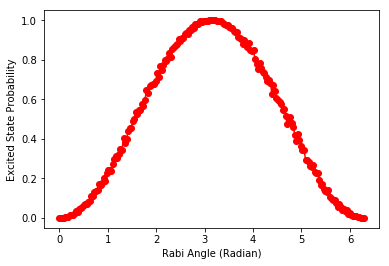

In [0]:
result = cirq.experiments.rabi_oscillations(
    sampler=cirq.Simulator(),  # In the future, sampler could point at real hardware.
    qubit=cirq.LineQubit(0)
)
result.plot()

**Testing**. The `cirq.testing` package has useful debugging and testing methods like `cirq.testing.assert_implements_consistent_protocols` and `cirq.testing.assert_allclose_up_to_global_phase`.


In [0]:
class InconsistentXGate(cirq.SingleQubitGate):

    def _decompose_(self, qubits):
        yield cirq.H(qubits[0])
        yield cirq.Z(qubits[0])
        yield cirq.H(qubits[0])

    def _unitary_(self):
        return np.array([[0, -1j], [1j, 0]])  # Oops! Y instead of X!

cirq.testing.assert_decompose_is_consistent_with_unitary(InconsistentXGate())

**Export**. You can export a circuit as QASM.

In [0]:
a, b, c = cirq.LineQubit.range(3)
circuit = cirq.Circuit.from_ops(cirq.H(a), cirq.H(c), cirq.CNOT(a, b), cirq.CCZ(a, b, c))
print(circuit.to_qasm())

// Generated from Cirq v0.5.0

OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [0, 1, 2]
qreg q[3];


h q[0];
h q[2];
cx q[0],q[1];
h q[2];
ccx q[0],q[1],q[2];
h q[2];



You can also turn a circuit into a link to the drag-and-drop web simulation Quirk (though somewhat inconveniently).

In [0]:
from cirq.contrib.quirk.export_to_quirk import circuit_to_quirk_url
print(circuit_to_quirk_url(circuit))

http://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C1%2C%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%5D%7D
